In [1]:
import numpy as np
import pandas as pd
from datetime import date
from datetime import datetime, timedelta
from matplotlib.pyplot import figure
from matplotlib import pyplot as plt
from lmfit import Model
import plotly.offline as py
import plotly.graph_objs as go
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [2]:
# Se cargan los datos de la fuente y se crea un Panda Data Frame para obtener los datos
url="https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
datos = pd.read_csv(url)

In [27]:
# Se define el pais a virualizar y los días a futuro a predecir.
#El nombre del país debe ajustarse al de los datos de entrada, que se encuentran en inglés
Pais="Colombia"
dias_predecir=10

#Presento los 30 países con la mayor tasa de contagio reportada en la última fecha en los datos.
#Esto, con el fin de ver cómo aparecen los paises en la lista y para ver que paises son los más afectados actualmente.
datos.groupby('Country/Region').sum().sort_values(datos.columns[-1], ascending=False).head(30).drop('Lat', axis=1).drop('Long', axis=1)

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20
Country/Region,,,,,,,,,,,,,,,,,,,,,
US,1,1,2,2,5,5,5,5,5,7,...,13677,19100,25489,33276,43847,53740,65778,83836,101657,121478
Italy,0,0,0,0,0,0,0,0,0,2,...,41035,47021,53578,59138,63927,69176,74386,80589,86498,92472
China,548,643,920,1406,2075,2877,5509,6087,8141,9802,...,81156,81250,81305,81435,81498,81591,81661,81782,81897,81999
Spain,0,0,0,0,0,0,0,0,0,0,...,17963,20410,25374,28768,35136,39885,49515,57786,65719,73235
Germany,0,0,0,0,0,1,4,4,4,5,...,15320,19848,22213,24873,29056,32986,37323,43938,50871,57695
France,0,0,2,3,3,3,4,5,5,5,...,10970,12758,14463,16243,20123,22622,25600,29551,33402,38105
Iran,0,0,0,0,0,0,0,0,0,0,...,18407,19644,20610,21638,23049,24811,27017,29406,32332,35408
United Kingdom,0,0,0,0,0,0,0,0,0,2,...,2716,4014,5067,5745,6726,8164,9640,11812,14745,17312
Switzerland,0,0,0,0,0,0,0,0,0,0,...,4075,5294,6575,7474,8795,9877,10897,11811,12928,14076


In [28]:
#Se manipulan los datos para seleccionar solo aquellos pertinentes al pais escogido
#Esto es, para solo tener los datos de los días desde que iniciaron los casos en el país en particular.

#Se eliminan los datos no importantes  y se agrupan los registros por país
Temporal=datos.drop('Lat', axis=1).drop('Long', axis=1).drop('Province/State', axis=1).groupby('Country/Region', as_index=False).sum()

#Se re estructuran los datos para facilitar el trabajo
Datos_Pais=Temporal.loc[Temporal['Country/Region'] == Pais].T.drop('Country/Region', axis=0)

#Se cálcula el índice del país en los datos origianales, dado que la columna en los datos modificados tendrá este nombre.
Indice_Pais=Temporal[Temporal['Country/Region'] == Pais].index.item()

#Se eliminan los datos nulos del país
Datos_Pais=Datos_Pais[Datos_Pais[Indice_Pais] != 0]

#Se extraen los datos para el modelado y se guardan en un np.array, que se requiere para el solver
confirmados=Datos_Pais[Indice_Pais]
confirmados=np.array(confirmados).astype(str).astype(int)

#Se crea una variable de "días desde el primer caso en el país".
#Para esto, se crea un arreglo enumera los datos que hay
x = np.arange(len(confirmados))

# Se guardan los datos cómo un DataFrame llamado df, cambiando los nombres de las columnas para ser mejor entendidas.
# Se presenta este DataFrame para su visualización
Datos_Pais=Datos_Pais.reset_index()
df=Datos_Pais.rename(columns={'index': "fecha", Indice_Pais: "confirmados"})
print("Datos de casos confirmados de "+str(Pais)+": ")
df

Datos de casos confirmados de Colombia: 


,fecha,confirmados
0,3/6/20,1
1,3/7/20,1
2,3/8/20,1
3,3/9/20,1
4,3/10/20,3
5,3/11/20,9
6,3/12/20,9
7,3/13/20,13
8,3/14/20,22
9,3/15/20,34


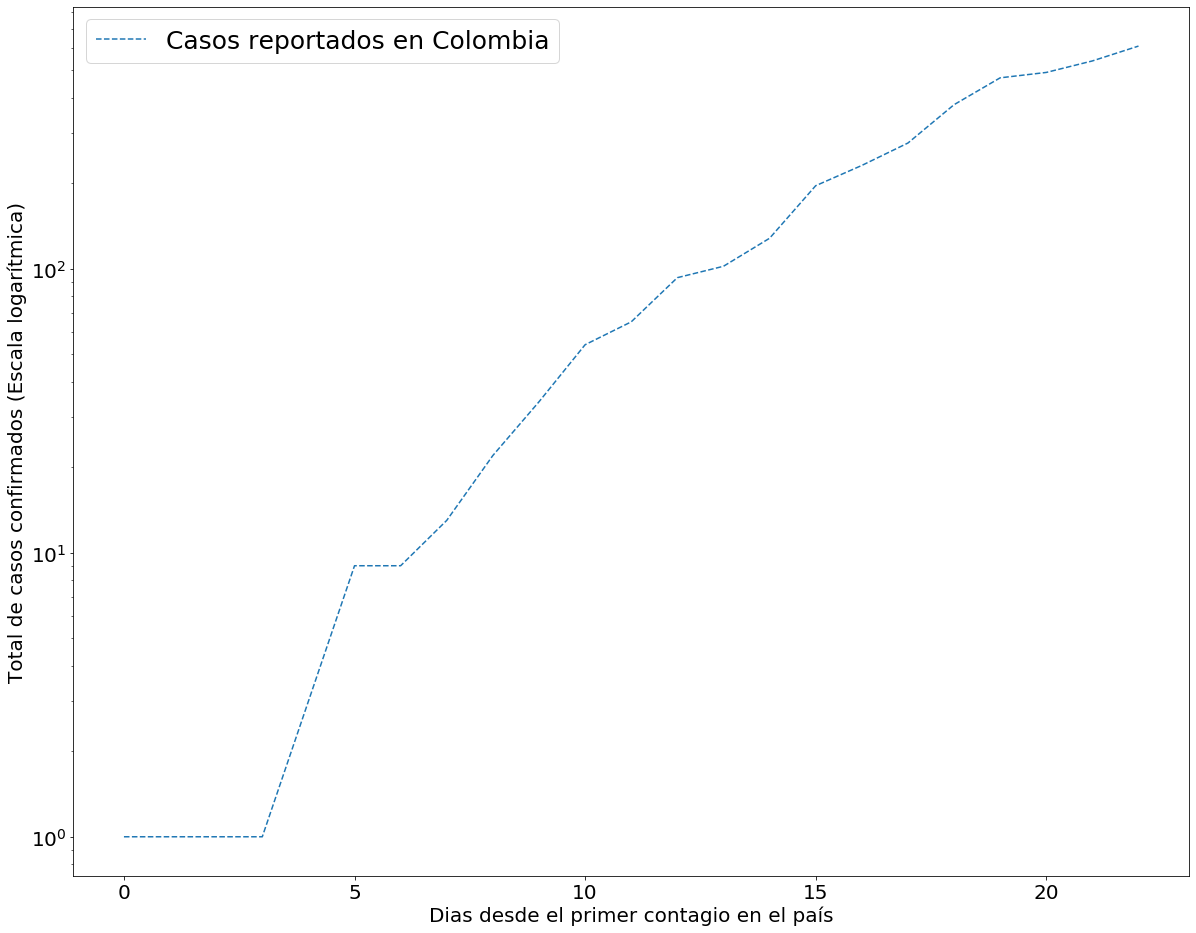

In [29]:
#Se presenta una gráfica sencilla, mostrando los casos reportados en  el pais en escala logarítima.
#Esto es, para observar el cambio en el comportamiento exponencial.

#Una curva exponencial en escala logarítmica se asemeja a una recta.
#Esto permite observar cambios en el comportamiento exponejcial más fácilmente.
plt.figure(figsize=(20,16))
plt.plot(x, confirmados, "--", label="Casos reportados en "+Pais)
plt.xlabel("Dias desde el primer contagio en el país", size=20)
plt.ylabel("Total de casos confirmados (Escala logarítmica)", size=20)
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.legend(prop={'size': 25}, loc='upper left')
plt.yscale('log')
plt.show()


In [30]:
#Se definen las funciones a utilizar en el modelo:
    #La ecuación de la curva logística  usar.
    #Las fórmulas usadas para el cálculo del error

def modelo_logistico(x, a, b, c):
        # a = Punto medio
        # b = crecimiento logístico
        # c = valor máximo
        return (c / (1 + np.exp(-b*(x-a))))
def avg_err(pcov):
        return np.round(np.sqrt(np.diag(pcov)).mean(), 2)

def mse(y,y_t):  
    return mean_squared_error(y,y_t)

    


La fórmula del modelo logístico a utilizar es:

\begin{align}
f(x) & =\frac{ c} {1 + e^{-b*(x-a)}}\\
\end{align}

Dónde:
1. El parámetro a simboliza el punto de inflexión de la curva (por la simetría en la misma y la traslación del a función). a simboliza el día en que hay mayor tasa de cambio en los casos confirmados, medido cómo días desde el primer caso.
2. El parámetro b representa la tasa de crecimiento logístico, o la inclinación de la curva.
3. El parámetro c simboliza el máximo de la curva, y por tanto, el máximo de contagios esperados.

In [31]:
#Se convierte la función del módelo en un elemento de clase Model para poder ajustar los datos a la ecuación:
logistico = Model(modelo_logistico)

#Se declaran las restricciones, de tal forma que el solver tenga algunos límites.
#Una forma de jugar con el módelo podría ser ajustar las restricciones.
#Los parámetros siguen la siguiente lógica:
    #a: el punto medio debe se mayor que el mínimo. El máximo se puede ajustar según la etapa del virus. Arbitrariamente,
    #se fija en 2 veces los días que han pasado desde la llegada del virus, pero podría ser mayor el valor.
    
    #b: La tasa debe ser positiva, y arbitrariamente se fija un límite de 1.
    
    #c: el valor máximo de la curva es superior a los casos actuales (dado que los casos actuales son iguales o menores
    # al máximo de casos posibles). El máximo se pone arbitrariamente cómo 1000 veces los casos actuales,
    

logistico.set_param_hint('a', min=1, max=3*len(confirmados))
logistico.set_param_hint('b', min=0.001, max=1)
logistico.set_param_hint('c', min=min(confirmados), max=1000*max(confirmados))

#Podría jugarse con los límites de los parámetros para probar casos... por ejemplo, si se supone que la infección va a durar
#más de dos meses (60 días), "a" debería ser superior a 30. Si se quiere fijar un mínimo de casos al final de la pandemía,
# puede ajustarse el parámetro c.

#Se resuelve el modelo y se presentan los resultados.
resultado = logistico.fit(confirmados, x=x, a=len(confirmados), b=0.5, c=max(confirmados))
resultado


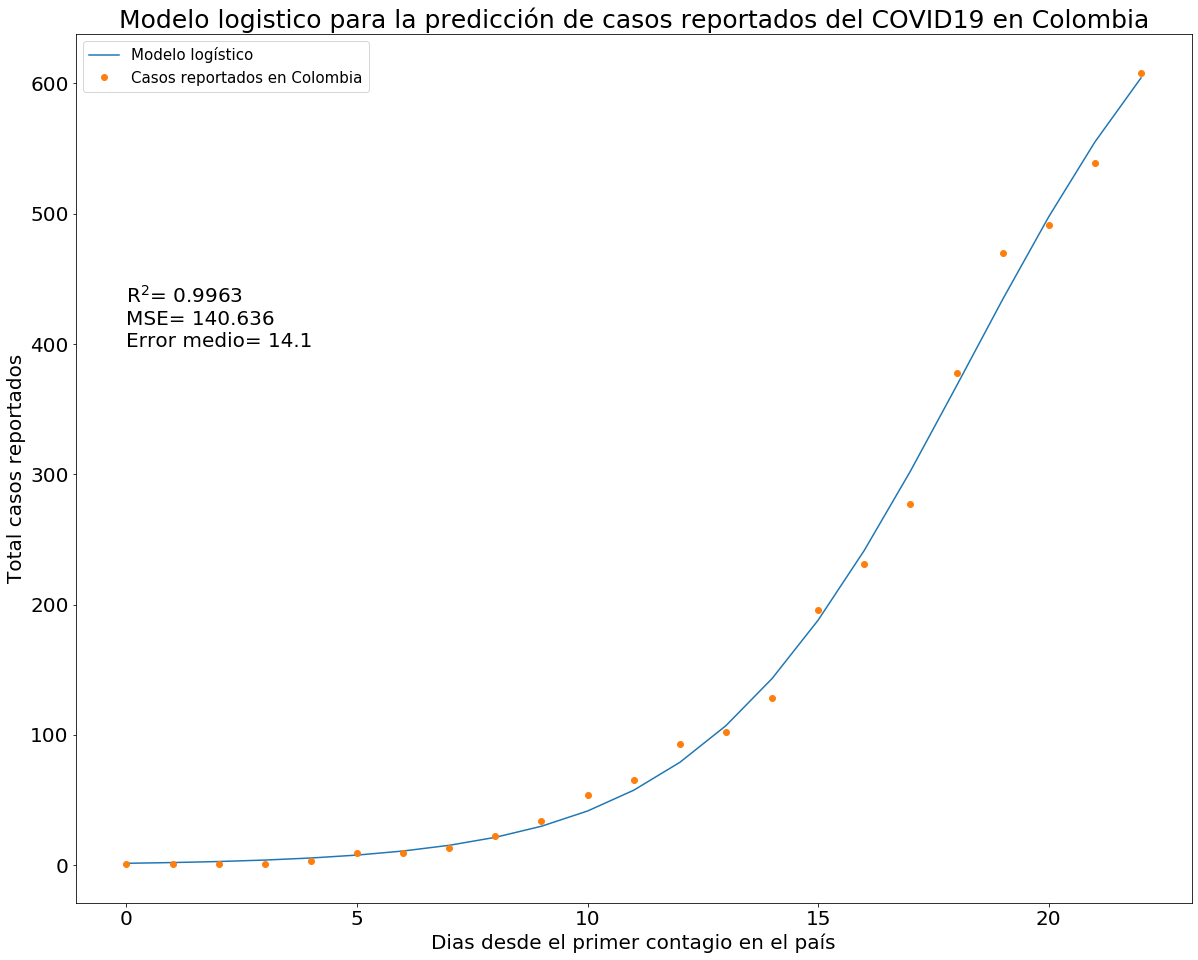

In [32]:
#Se toman los valores para la gráfica de los valores del modelo:

x_m1 = np.arange(len(confirmados))
y_m1 = resultado.eval(x=x_m1)

#Se calculan los parámetros de desempeño.
mse_v=str(round(mse(confirmados,y_m1),3))
error_medio=str(avg_err(resultado.covar))
r2=str(round(r2_score(confirmados,  resultado.eval(x=x, \
a=resultado.params['a'].value, b=resultado.params['b'].value, c=resultado.params['c'].value)),5))


#Se dibuja la gráfica de acuerdo a los parámetros:
plt.figure(figsize=(20,16))

plt.title("Modelo logistico para la predicción de casos reportados del COVID19 en "+Pais, size=25)
plt.text(0,0.8*y_m1[-3],"R$^{2}$= "+r2+"\nMSE= "+mse_v+"\nError medio= "+error_medio,size=20)
plt.plot(x_m1, y_m1,
    label="Modelo logístico")
plt.plot(confirmados, "o", label="Casos reportados en "+Pais)
plt.xlabel("Dias desde el primer contagio en el país", size=20)
plt.ylabel("Total casos reportados", size=20)
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.legend(prop={'size': 15})

plt.show()

Ahora, se procede a generar una gráfica rica en información, cómo principal resultado del código. Esta gráfica:
1. Mostrará los datos históricos vs los datos del modelo.
2. Mostrará la predicción del modelo para los días que se determinen
3. Mostrará el error de la predicción para todos los puntos.
4. Mostrará el pico de casos confirmados (a) y la fecha actual
5. Presentará la predicción para el día siguiente, y el valor de casos actuales
6. Mostrará los parámetros de la función logística y y medidas de desempeño.

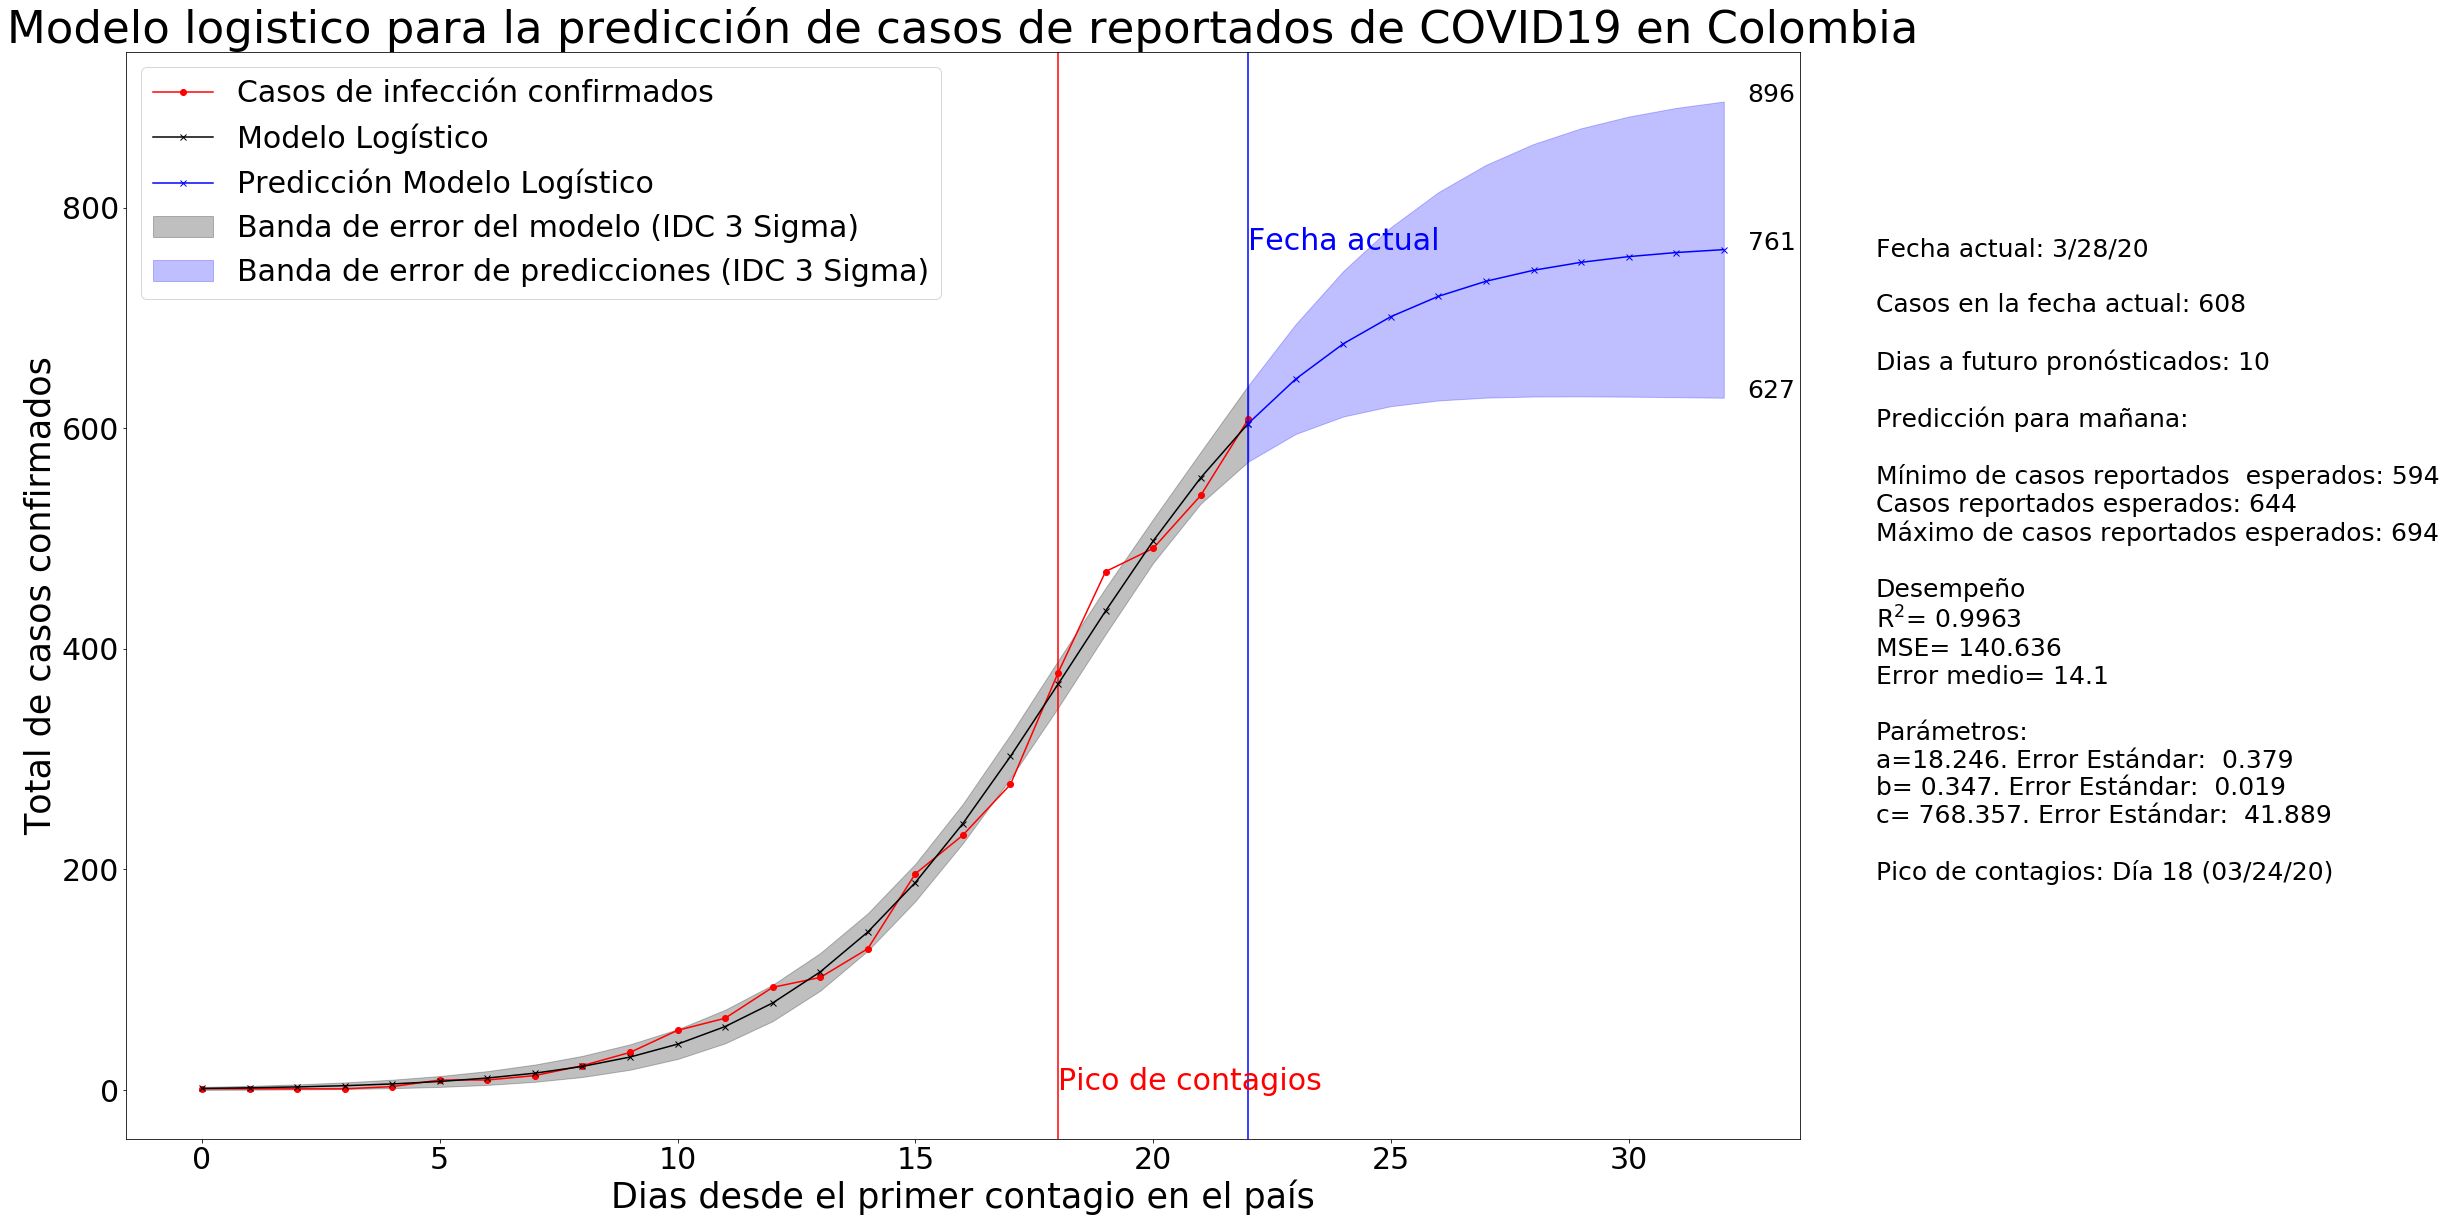

In [33]:
#Se calculan los valores del modelo para la fecha actual+los días solicitados.
x_m = np.arange(len(confirmados)+dias_predecir)
y_m = resultado.eval(x=x_m)

# Se inicializa la figura, declarando su tamaño:
plt.figure(figsize=(30,20))
#Se calcula el día pico de infección para presentarse cómo fecha. 
#Para ello, se usan los datos originales para obtener la fecha del primer contagio.
#Dado que el parámetro a será afin al valor en X del punto de inflexión por la simetría de la curva,
#se utiliza este valor para la estimación del día de infecciones pico.
#Cabe resaltar que este valor puede variar de acuerdo a su error estándar

#Básicamente, a y el eje X de los datos representan "días a partir del primer caso", por lo que tomando el primer día,
#se cálcula el valor de "a días después del primer caso", presentado cómo una fecha.

dia_pico = datetime.strftime(datetime.strptime(df["fecha"][0], "%m/%d/%y")+timedelta(days=int(resultado.params['a'].value)), "%m/%d/%y")

# Se le da nombre a la gráfica:
plt.title("Modelo logistico para la predicción de casos de reportados de COVID19 en "+Pais, size=45)

#Se nombran los ejes y se les asigna un tamaño (tanto a los nómbres cómo a sus valores):

plt.xlabel("Dias desde el primer contagio en el país", size=35)
plt.ylabel("Total de casos confirmados", size=35)
plt.xticks(size = 30)
plt.yticks(size = 30)

#Se incorporan a la gráfica los datos históricos
    
plt.plot(x, confirmados, c='r', marker="o", label = "Casos de infección confirmados")

#Se dibujan las líneas horizontales de la gráfica y sus leyendas con los colores respectivos.

plt.axvline(x[-1], color='b')
plt.text(x[-1],max(y_m), "Fecha actual", color='b', size=30)
plt.axvline(int(resultado.params['a'].value), color='r')
plt.text(int(resultado.params['a'].value),0, "Pico de contagios", color='r', size=30)

#Se incorpora la gráfica de los valores del modelo hasta la fecha actual
plt.plot(x, resultado.best_fit, c='k', marker="x", label="Modelo Logístico")

#Se calcula e incorpora la gráfica del intervalo de confianza (IDC) para 3 sigmas:

error_datos = resultado.eval_uncertainty(resultado.params, sigma=3)   
plt.fill_between(x,
                 resultado.best_fit-error_datos,
                 resultado.best_fit+error_datos,
                 color="k", alpha=0.25,
                 label='Banda de error del modelo (IDC 3 Sigma)')


#Se calculan los valores e incorpora la gráfica de la predicción del módelo de acuerdo a los días solicitados:

dias_pred = np.arange(len(confirmados)-1,len(confirmados)+dias_predecir,1)
valor_pred = resultado.eval(x=dias_pred)
plt.plot(dias_pred, valor_pred, c='b', marker="x", label="Predicción Modelo Logístico")
error_pred = resultado.eval_uncertainty(x=dias_pred, sigma=3)


#Se calculan los valores e incorpora la gráfica del intervalo de confianza para las predicciones, con 3 sigma:
esperado=str(int(y_m[len(confirmados)]))
inferior=str(int(valor_pred[1]-error_pred[1]))
superior=str(int(valor_pred[1]+error_pred[1]))
plt.fill_between(dias_pred,
                 valor_pred-error_pred,
                 valor_pred+error_pred,
                 color="b", alpha=0.25,
                 label='Banda de error de predicciones (IDC 3 Sigma)')

#Se incorporan las etiquetas de los datos del últmo día predecido (de acuerdo al IDC calculado):

plt.text(x_m[-1]+.5, y_m[-1], str(int(y_m[-1])), size = 25)
plt.text(x_m[-1]+.5, valor_pred[-1] +error_pred[-1], str(int(valor_pred[-1]+error_pred[-1])), size = 25)
plt.text(x_m[-1]+.5, valor_pred[-1] -error_pred[-1], str(int(valor_pred[-1]-error_pred[-1])), size = 25)

#Se añade todo el texto de la derecha de la gráfica, con la información pertinente del modelo:

plt.text(max(x_m)*1.1, 0.25*max(y_m),\
        "Fecha actual: "+str(df["fecha"][len(confirmados)+-1])\
         +"\n\nCasos en la fecha actual: "+str(confirmados[-1])\
         +"\n\nDias a futuro pronósticados: " + str(dias_predecir)\
         +"\n\n"+"Predicción para mañana:\n\nMínimo de casos reportados  esperados: " \
         +inferior+"\nCasos reportados esperados: "+esperado+"\nMáximo de casos reportados esperados: "+superior\
         +"\n\n"+"Desempeño\nR$^{2}$= "+r2+"\nMSE= "+mse_v+"\nError medio= "+error_medio\
         +"\n\nParámetros:\na="\
         +str(round(resultado.params['a'].value,3))+". Error Estándar:  "+str(round(resultado.params['a'].stderr,3))\
         +"\nb= "+str(round(resultado.params['b'].value,3))+". Error Estándar:  "+str(round(resultado.params['b'].stderr,3))\
         +"\nc= "+str(round(resultado.params['c'].value,3))+". Error Estándar:  "+str(round(resultado.params['c'].stderr,3))\
         +"\n\n"+"Pico de contagios: Día "  \
         +str(int(resultado.params['a'].value)) + " (" + dia_pico + ")",size=25)

# Se añade el cuadro de leyenda en la equina superior izquierda:
plt.legend(prop={'size': 30}, loc='upper left')

#Se toma el dato del día del último registro y se guarda la gráfica bajo el equema "dd-mm-yy-Pais.png"

fecha_pron=str(df["fecha"][len(confirmados)+-1])
fecha_pron=fecha_pron.replace("/","-")
plt.savefig(fecha_pron+"-"+Pais+'.png')








In [34]:
#Se declara un DataFrame vacío con las columnas pertinentes, es decir, la fecha, los casos reportados,
#los límites superior e inferior del intervalo de confianza y la predicción del modelo:
prediccion=pd.DataFrame({"Fecha":[], "Casos reportados":[],"Límite Inferior":[], "Predicción":[], "Límite Superior":[]}) 

#Usando un for, se pobla este DataFrame con los valores de casos confirmados del país VS los valores del modelo,
#para todas las fechas pasadas.
for dia, pred, error, y in zip(x, resultado.best_fit, error_datos ,confirmados):
    pday = datetime.strftime(datetime.strptime(df["fecha"][0], "%m/%d/%y")+timedelta(days=int(dia)), "%m/%d/%y")
    prediccion=prediccion.append({'Fecha' : pday,"Casos reportados" : y, "Límite Inferior":round(pred-error), "Predicción":round(pred),\
                      "Límite Superior": round(pred+error)}, ignore_index=True)
    
#Usando un for, se pobla el resto del DataFrame con las predicciones del modelo para fechas futuras, de acuerdo
#a la cantidad de días solicitados. Se utiliza lo cálculado para la gráfica.
#El valor de [1:] es por que el elemento [0] es el valor al día de hoy, que es necesario que se encuentre
#en la predicción y su IDC para que la gráfica sea continua... Así que, al poner [1:], se evita que se muestra la fecha
#actual de manera duplicada (pues ya se puso en el for anterior).
#Dado que no hay ingreso a los Casos reportados, estos se mostrarán como NaN.

    
for dia, pred, error in zip(dias_pred[1:], valor_pred[1:], error_pred[1:]):
    pday = datetime.strftime(datetime.strptime(df["fecha"][0], "%m/%d/%y")+timedelta(days=int(dia)), "%m/%d/%y")
    prediccion=prediccion.append({'Fecha' : pday, "Límite Inferior":round(pred-error), "Predicción":round(pred), \
                      "Límite Superior":round(pred+error) }, ignore_index=True)

#Se guarda el DataFrame como un CSV con un nombre "Prediccionesy datos históricos del *dd-mm-yy* para *pais*"
#Adicionalmente, se presentan los datos de la predicción y de hoy para su inspección.

#Es de resaltar que, cómo se puede apreciar en los for, todos los valores se aproximan 
#(no hay fracciones de personas infectadas).

#Si bien esto agrega al error, es una lectura más intuitiva del dato. 


prediccion.to_csv("Predicciones y datos historicos del "+fecha_pron+" para "+Pais+".csv", encoding='utf-8', index=False)
prediccion.tail(dias_predecir+1)

,Fecha,Casos reportados,Límite Inferior,Predicción,Límite Superior
22,03/28/20,608.0,570.0,604.0,639.0
23,03/29/20,NaN,595.0,645.0,694.0
24,03/30/20,NaN,611.0,677.0,743.0
25,03/31/20,NaN,620.0,701.0,782.0
26,04/01/20,NaN,625.0,720.0,814.0
27,04/02/20,NaN,628.0,733.0,839.0
28,04/03/20,NaN,629.0,743.0,858.0
29,04/04/20,NaN,629.0,750.0,872.0
30,04/05/20,NaN,629.0,756.0,883.0
31,04/06/20,NaN,628.0,759.0,890.0


In [35]:
#Se genera una visualización en Plotly offline para comparar el pronóstico con el dato real de forma más interactiva
dat=[
     go.Scatter(x=prediccion['Fecha'], y=prediccion['Límite Superior'], name='Límite Superior', mode='lines', line_color='gray') ,   
     go.Scatter(x=prediccion['Fecha'], y=prediccion['Límite Inferior'], name='Límite Inferior', mode='lines', fill='tonexty',line_color='gray')  ,
     go.Scatter(x=prediccion['Fecha'], y=prediccion['Predicción'], name='Modelo', line_color='gray') ,
     go.Scatter(x=prediccion['Fecha'], y=prediccion['Casos reportados'], name='Datos', mode='markers', line_color='red')
]
fig=go.Figure(dat)
fig.update_layout( hovermode='x')
fig.update_layout(
    title="Modelo logístico para la predicción del COVID19 en "+str(Pais),
    xaxis_title="Fecha",
    yaxis_title="Casos confirmados",
    font=dict(
        family="Courier New, monospace",
        size=13,
        color="#7f7f7f"
    ))
py.iplot(fig)


Para una mayor facilidad de uso, se declara una función con dos parámetros:

1. **Pais**: ¿Qué país se desea observar?
2. **días_predecir**: ¿A cuántos días a futuro debe realizarse el pronóstico?

Esta función básicamente corre "las partes importantes" del código, creando los informes importantes.


In [36]:

def modelo_rlog_covid_pais_dias_a_predecir (Pais, dias_predecir):
    
    Temporal=datos.drop('Lat', axis=1).drop('Long', axis=1).drop('Province/State', axis=1).groupby('Country/Region', as_index=False).sum()
    Datos_Pais=Temporal.loc[Temporal['Country/Region'] == Pais].T.drop('Country/Region', axis=0)
    Indice_Pais=Temporal[Temporal['Country/Region'] == Pais].index.item()
    Datos_Pais=Datos_Pais[Datos_Pais[Indice_Pais] != 0]
    confirmados=Datos_Pais[Indice_Pais]
    x = np.arange(len(confirmados))
    confirmados=np.array(confirmados).astype(str).astype(int)
    Datos_Pais=Datos_Pais.reset_index()
    df=Datos_Pais.rename(columns={'index': "fecha", Indice_Pais: "confirmados"})
    
    print("Datos de casos confirmados de "+str(Pais)+": ")
    print(df)

    def modelo_logistico(x, a, b, c):
        return (c / (1 + np.exp(-b*(x-a))))
    
    def avg_err(pcov):
        return np.round(np.sqrt(np.diag(pcov)).mean(), 2)

    def mse(y,y_t):  
        return mean_squared_error(y,y_t)
    
    logistico = Model(modelo_logistico)
    logistico.set_param_hint('a', min=1, max=3*len(confirmados))
    logistico.set_param_hint('b', min=0.001, max=1)
    logistico.set_param_hint('c', min=min(confirmados), max=1000*max(confirmados))
    resultado = logistico.fit(confirmados, x=x, a=len(confirmados), b=0.5, c=max(confirmados))
    x_m = np.arange(len(confirmados)+dias_predecir)
    y_m = resultado.eval(x=x_m)

    plt.figure(figsize=(30,20))
    dia_pico = datetime.strftime(datetime.strptime(df["fecha"][0], "%m/%d/%y")+timedelta(days=int(resultado.params['a'].value)), "%m/%d/%y")
    plt.title("Modelo logistico para la predicción de casos reportados de COVID19 en "+Pais, size=45)
    plt.xlabel("Dias desde el primer contagio en el país", size=35)
    plt.ylabel("Total de casos confirmados", size=35)
    plt.xticks(size = 30)
    plt.yticks(size = 30)
    plt.plot(x, confirmados, c='r', marker="o", label = "Casos de infección confirmados")
    plt.axvline(x[-1], color='b')
    plt.text(x[-1],max(y_m), "Fecha actual", color='b', size=30)
    plt.axvline(int(resultado.params['a'].value), color='r')
    plt.text(int(resultado.params['a'].value),0, "Pico de contagios", color='r', size=30)
    plt.plot(x, resultado.best_fit, c='k', marker="x", label="Modelo Logístico")
    error_datos = resultado.eval_uncertainty(resultado.params, sigma=3)   
    plt.fill_between(x,
                     resultado.best_fit-error_datos,
                     resultado.best_fit+error_datos,
                     color="k", alpha=0.25,
                     label='Banda de error del modelo (IDC 3 Sigma)')
    dias_pred = np.arange(len(confirmados)-1,len(confirmados)+dias_predecir,1)
    valor_pred = resultado.eval(x=dias_pred)
    plt.plot(dias_pred, valor_pred, c='b', marker="x", label="Predicción Modelo Logístico")
    error_pred = resultado.eval_uncertainty(x=dias_pred, sigma=3)
    esperado=str(int(y_m[len(confirmados)]))
    inferior=str(int(valor_pred[1]-error_pred[1]))
    superior=str(int(valor_pred[1]+error_pred[1]))
    plt.fill_between(dias_pred,
                     valor_pred-error_pred,
                     valor_pred+error_pred,
                     color="b", alpha=0.25,
                     label='Banda de error de predicciones (IDC 3 Sigma)')

    plt.text(x_m[-1]+.5, y_m[-1], str(int(y_m[-1])), size = 25)
    plt.text(x_m[-1]+.5, valor_pred[-1] +error_pred[-1], str(int(valor_pred[-1]+error_pred[-1])), size = 25)
    plt.text(x_m[-1]+.5, valor_pred[-1] -error_pred[-1], str(int(valor_pred[-1]-error_pred[-1])), size = 25)
    plt.text(max(x_m)*1.1, 0.25*max(y_m),\
            "Fecha actual: "+str(df["fecha"][len(confirmados)+-1])\
             +"\n\nCasos en la fecha actual: "+str(confirmados[-1])\
             +"\n\nDias a futuro pronósticados: " + str(dias_predecir)\
             +"\n\n"+"Predicción para mañana:\n\nMínimo de casos reportados  esperados: " \
             +inferior+"\nCasos reportados esperados: "+esperado+"\nMáximo de casos reportados esperados: "+superior\
             +"\n\n"+"Desempeño\nR$^{2}$= "+r2+"\nMSE= "+mse_v+"\nError medio= "+error_medio\
             +"\n\nParámetros:\na="\
             +str(round(resultado.params['a'].value,3))+". Error Estándar:  "+str(round(resultado.params['a'].stderr,3))\
             +"\nb= "+str(round(resultado.params['b'].value,3))+". Error Estándar:  "+str(round(resultado.params['b'].stderr,3))\
             +"\nc= "+str(round(resultado.params['c'].value,3))+". Error Estándar:  "+str(round(resultado.params['c'].stderr,3))\
             +"\n\n"+"Pico de contagios: Día "  \
             +str(int(resultado.params['a'].value)) + " (" + dia_pico + ")",size=25)
    plt.legend(prop={'size': 30}, loc='upper left')
    fecha_pron=str(df["fecha"][len(confirmados)+-1])
    fecha_pron=fecha_pron.replace("/","-")
    plt.savefig(fecha_pron+"-"+Pais+'.png')
    plt.show()
    prediccion=pd.DataFrame({"Fecha":[], "Casos reportados":[],"Límite Inferior":[], "Predicción":[], "Límite Superior":[]}) 
    for dia, pred, error, y in zip(x, resultado.best_fit, error_datos ,confirmados):
        pday = datetime.strftime(datetime.strptime(df["fecha"][0], "%m/%d/%y")+timedelta(days=int(dia)), "%m/%d/%y")
        prediccion=prediccion.append({'Fecha' : pday,"Casos reportados" : y, "Límite Inferior":round(pred-error), "Predicción":round(pred),\
                          "Límite Superior": round(pred+error)}, ignore_index=True)
    for dia, pred, error in zip(dias_pred[1:], valor_pred[1:], error_pred[1:]):
        pday = datetime.strftime(datetime.strptime(df["fecha"][0], "%m/%d/%y")+timedelta(days=int(dia)), "%m/%d/%y")
        prediccion=prediccion.append({'Fecha' : pday, "Límite Inferior":round(pred-error), "Predicción":round(pred), \
                          "Límite Superior":round(pred+error) }, ignore_index=True)

    prediccion.to_csv("Predicciones y datos historicos del "+fecha_pron+" para "+Pais+".csv", encoding='utf-8', index=False)
    
    dat=[
     go.Scatter(x=prediccion['Fecha'], y=prediccion['Límite Superior'], name='Límite Superior', mode='lines', line_color='gray') ,   
     go.Scatter(x=prediccion['Fecha'], y=prediccion['Límite Inferior'], name='Límite Inferior', mode='lines', fill='tonexty',line_color='gray')  ,
     go.Scatter(x=prediccion['Fecha'], y=prediccion['Predicción'], name='Modelo', line_color='gray') ,
     go.Scatter(x=prediccion['Fecha'], y=prediccion['Casos reportados'], name='Datos', mode='markers', line_color='red')
    ]
    fig=go.Figure(dat)
    fig.update_layout( hovermode='x')
    fig.update_layout(
        title="Modelo logístico para la predicción del COVID19 en "+str(Pais),
        xaxis_title="Fecha",
        yaxis_title="Casos confirmados",
        font=dict(
            family="Courier New, monospace",
            size=13,
            color="#7f7f7f"
        ))
    py.iplot(fig)

    return prediccion


In [15]:
url="https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
datos = pd.read_csv(url)

Datos de casos confirmados de US: 
      fecha confirmados
0   1/22/20           1
1   1/23/20           1
2   1/24/20           2
3   1/25/20           2
4   1/26/20           5
..      ...         ...
62  3/24/20       53740
63  3/25/20       65778
64  3/26/20       83836
65  3/27/20      101657
66  3/28/20      121478

[67 rows x 2 columns]


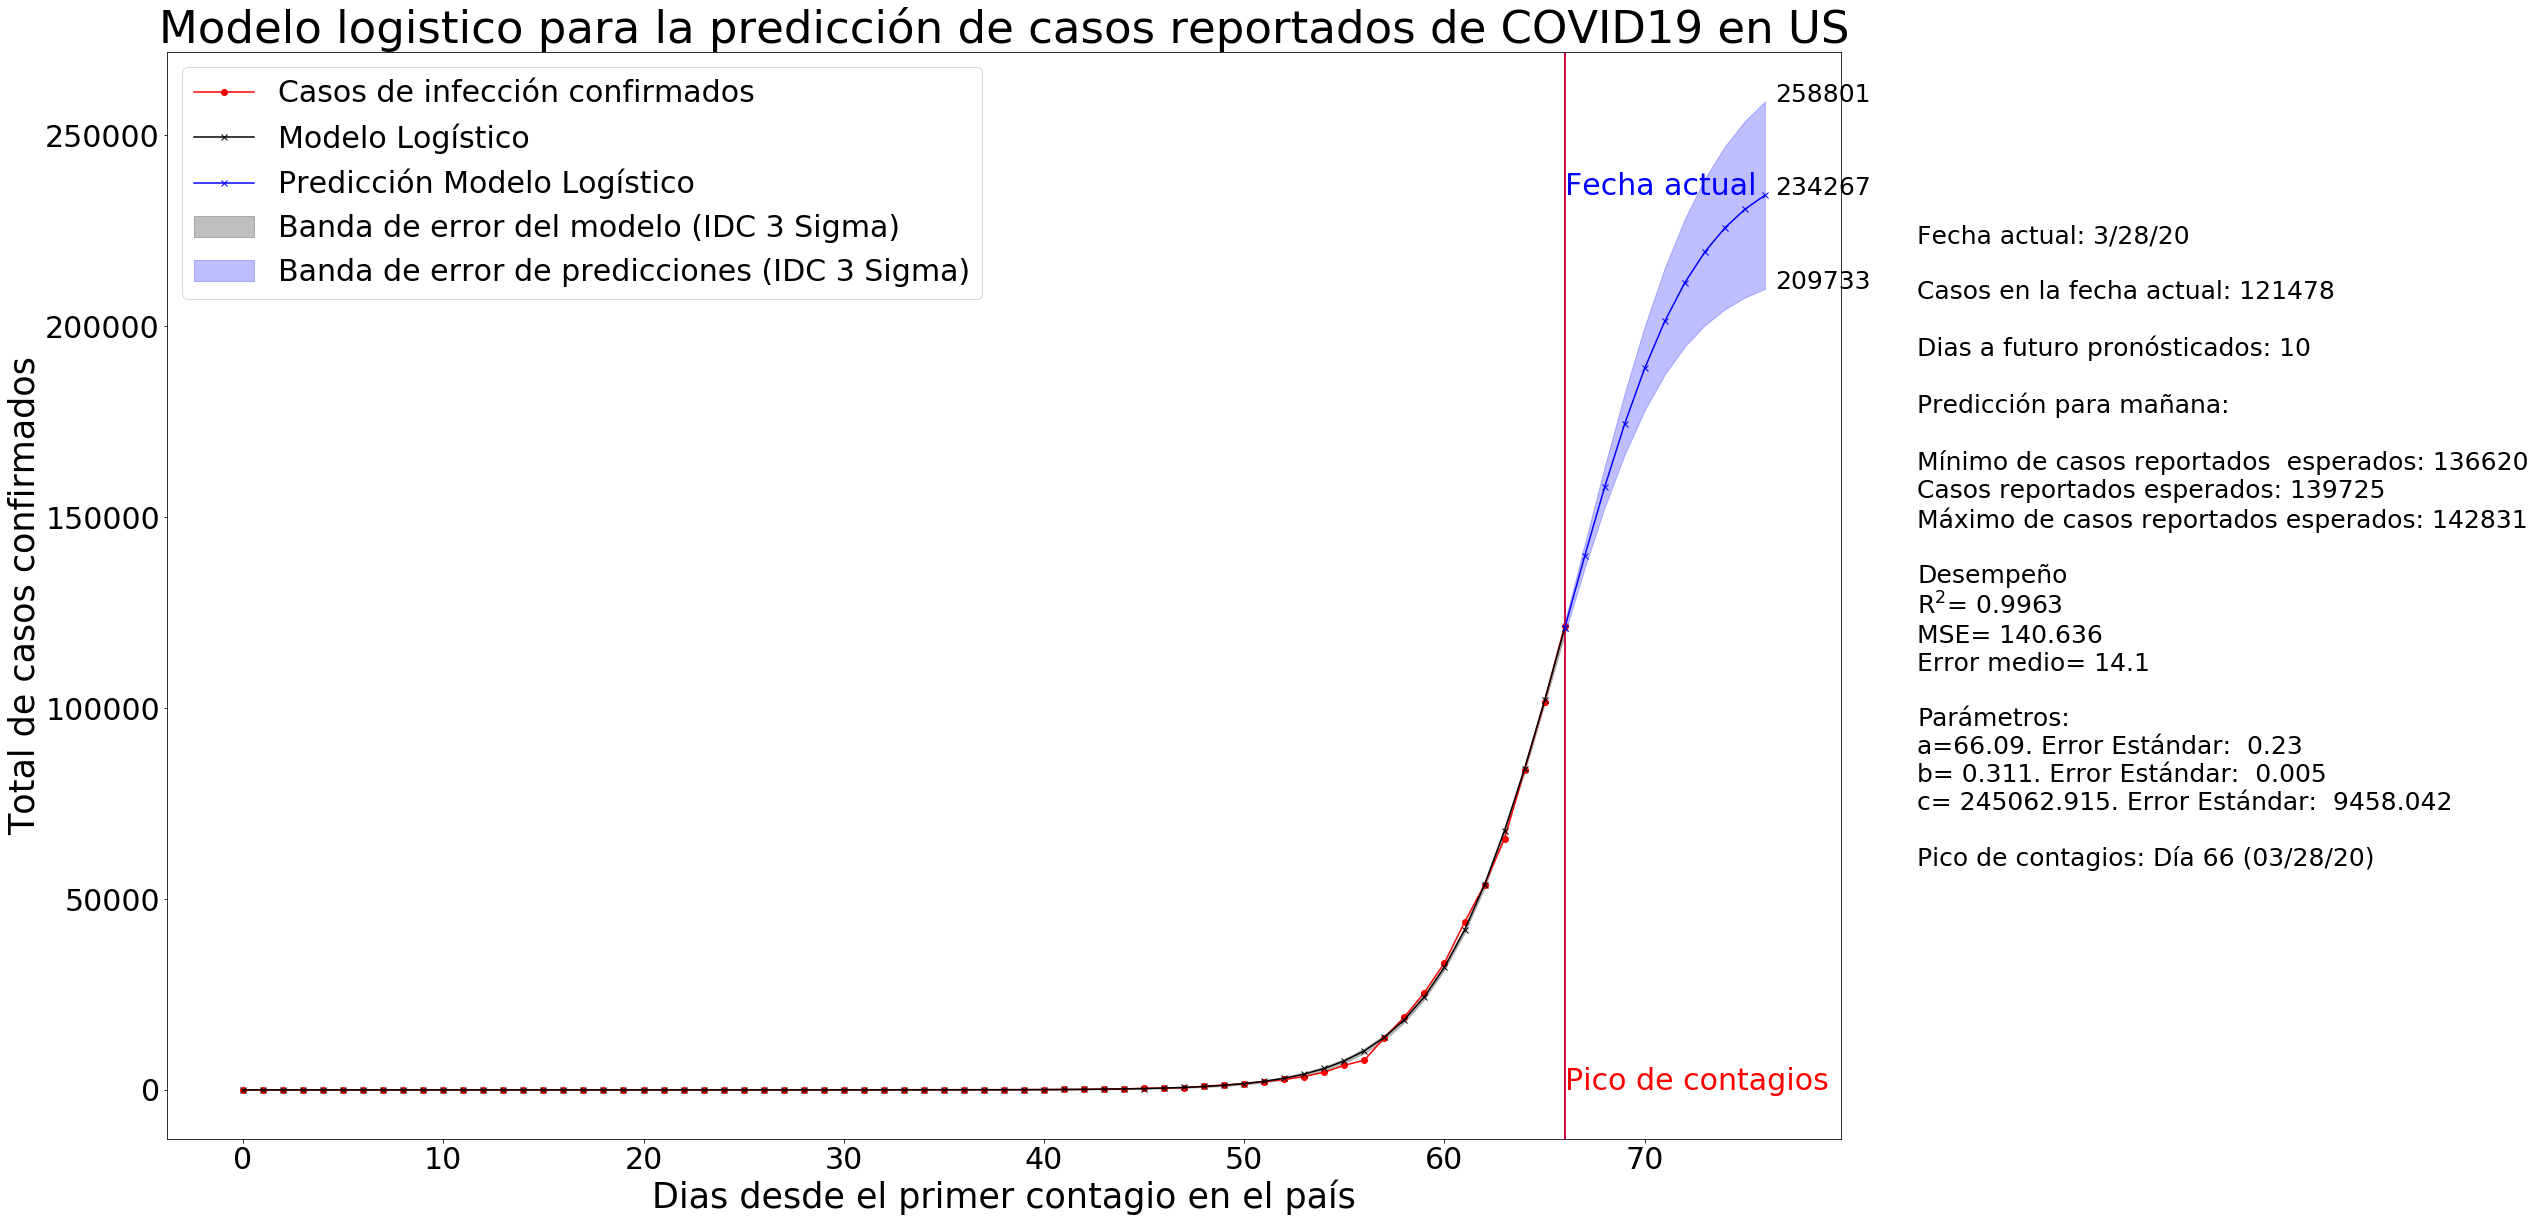

Predicciones y datos históricos para US


,Fecha,Casos reportados,Límite Inferior,Predicción,Límite Superior
66,03/28/20,121478.0,119229.0,120815.0,122401.0
67,03/29/20,NaN,136620.0,139726.0,142831.0
68,03/30/20,NaN,152516.0,157837.0,163157.0
69,03/31/20,NaN,166390.0,174408.0,182426.0
70,04/01/20,NaN,177989.0,188951.0,199912.0
71,04/02/20,NaN,187334.0,201252.0,215169.0
72,04/03/20,NaN,194639.0,211338.0,228037.0
73,04/04/20,NaN,200213.0,219398.0,238583.0
74,04/05/20,NaN,204389.0,225708.0,247027.0
75,04/06/20,NaN,207476.0,230569.0,253662.0


In [37]:
Pais="US"
dias_predecir=10
prediccion=modelo_rlog_covid_pais_dias_a_predecir(Pais, dias_predecir)
print("Predicciones y datos históricos para "+Pais)
prediccion.tail(dias_predecir+1)

Datos de casos confirmados de Italy: 
      fecha confirmados
0   1/31/20           2
1    2/1/20           2
2    2/2/20           2
3    2/3/20           2
4    2/4/20           2
5    2/5/20           2
6    2/6/20           2
7    2/7/20           3
8    2/8/20           3
9    2/9/20           3
10  2/10/20           3
11  2/11/20           3
12  2/12/20           3
13  2/13/20           3
14  2/14/20           3
15  2/15/20           3
16  2/16/20           3
17  2/17/20           3
18  2/18/20           3
19  2/19/20           3
20  2/20/20           3
21  2/21/20          20
22  2/22/20          62
23  2/23/20         155
24  2/24/20         229
25  2/25/20         322
26  2/26/20         453
27  2/27/20         655
28  2/28/20         888
29  2/29/20        1128
30   3/1/20        1694
31   3/2/20        2036
32   3/3/20        2502
33   3/4/20        3089
34   3/5/20        3858
35   3/6/20        4636
36   3/7/20        5883
37   3/8/20        7375
38   3/9/20        9172
39

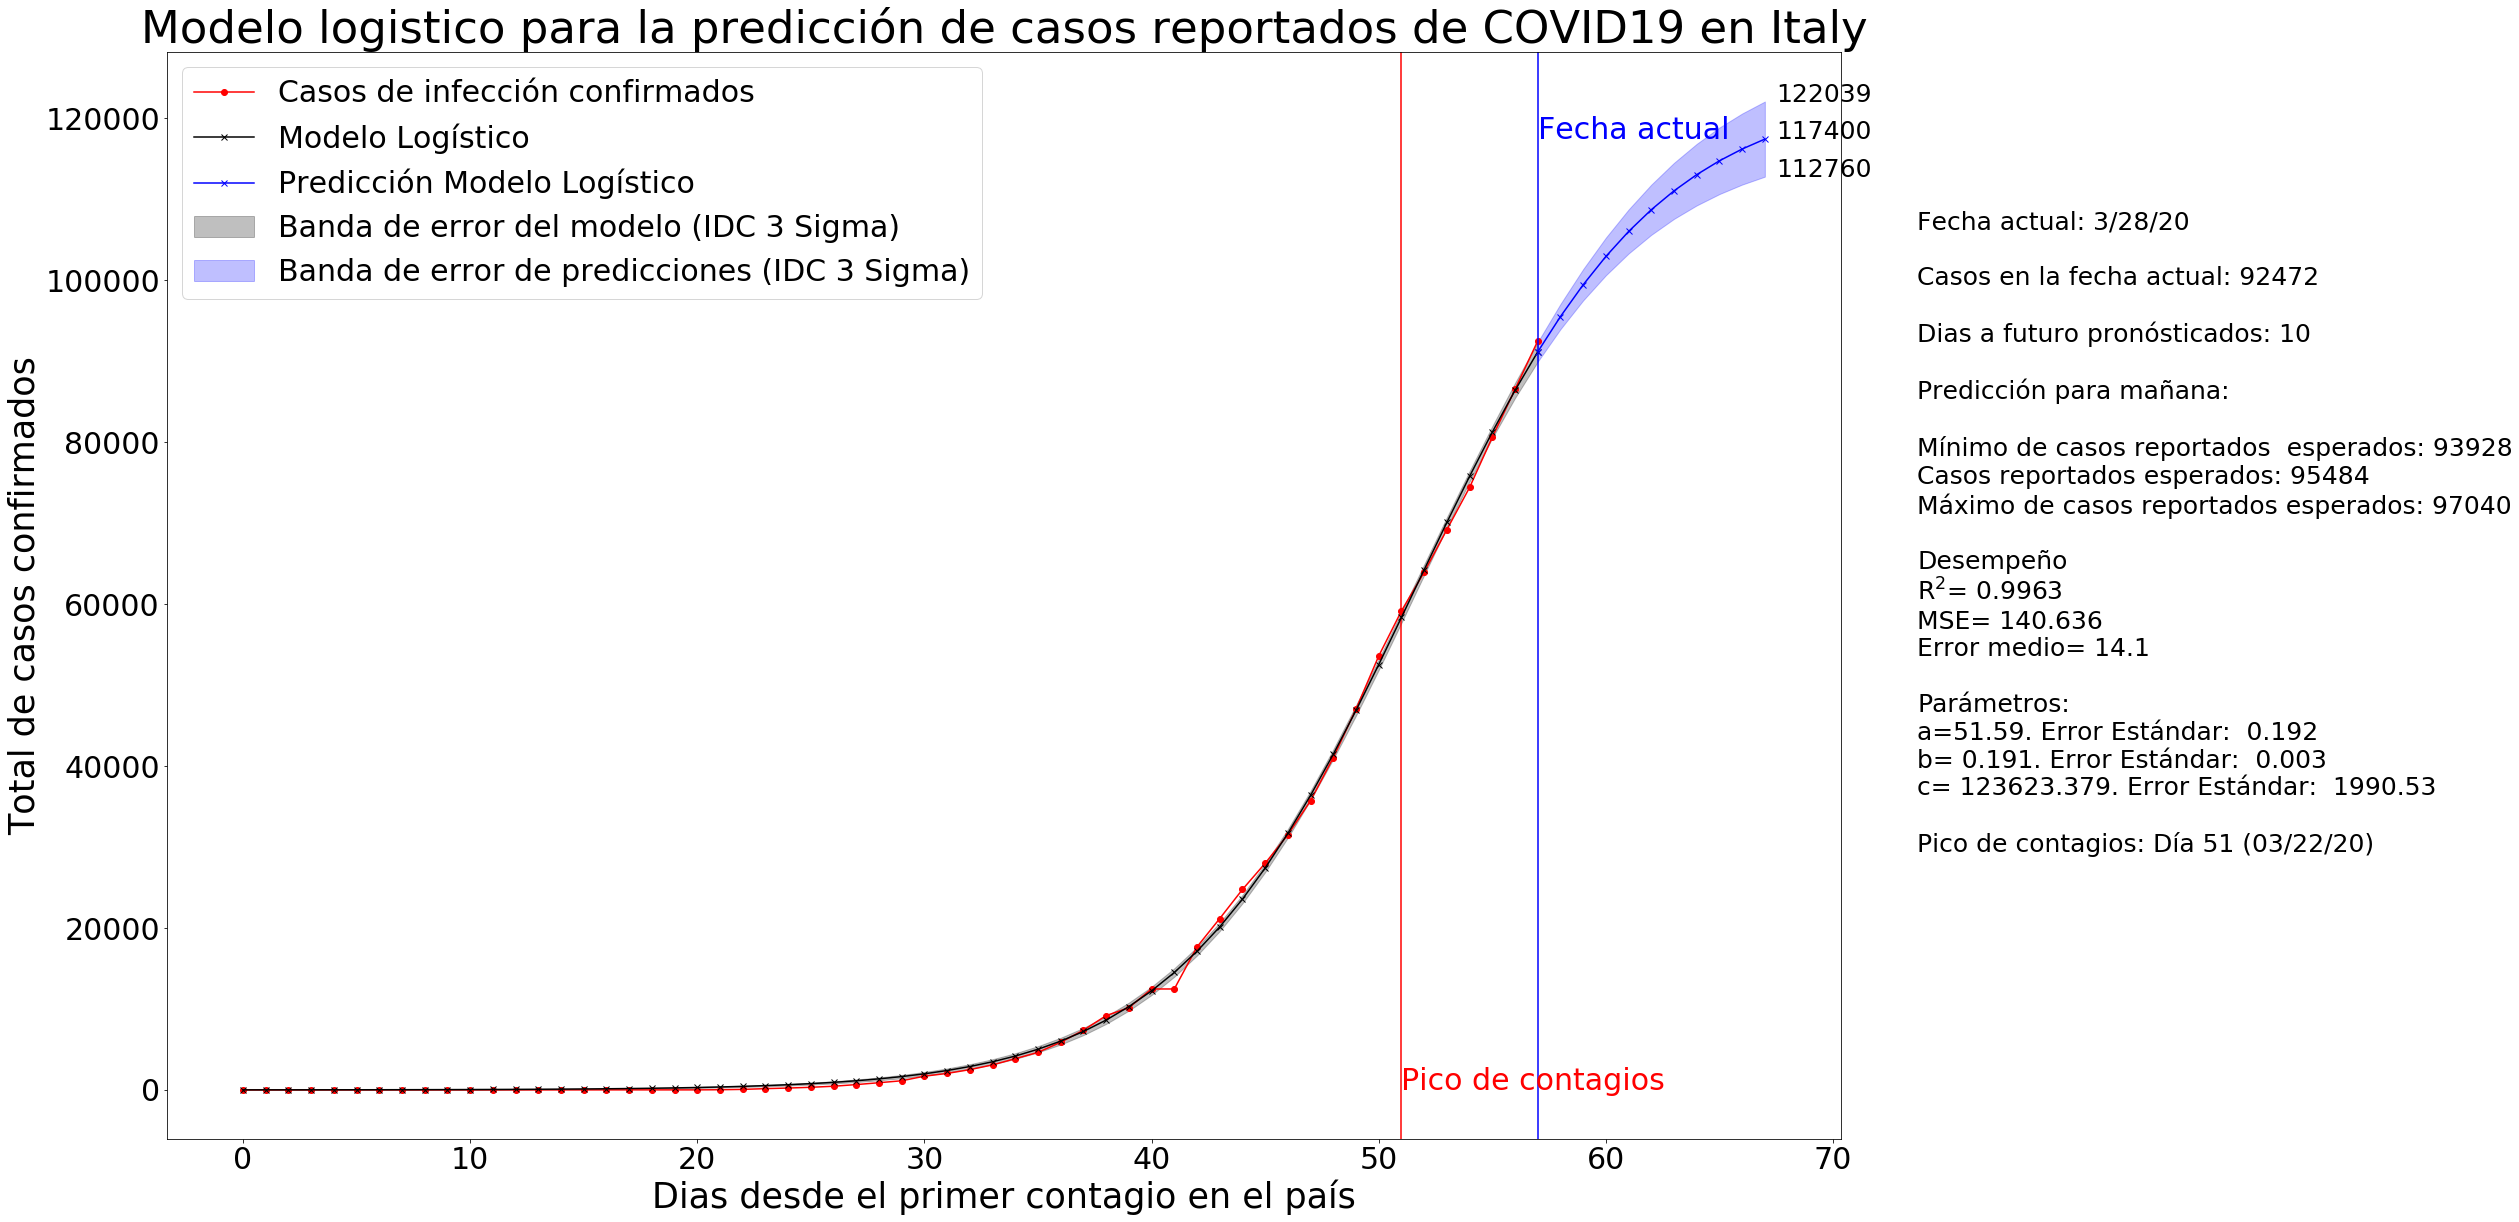

Predicciones y datos históricos para Italy


,Fecha,Casos reportados,Límite Inferior,Predicción,Límite Superior
57,03/28/20,92472.0,89915.0,91129.0,92343.0
58,03/29/20,NaN,93928.0,95485.0,97041.0
59,03/30/20,NaN,97478.0,99412.0,101345.0
60,03/31/20,NaN,100584.0,102909.0,105235.0
61,04/01/20,NaN,103273.0,105991.0,108710.0
62,04/02/20,NaN,105582.0,108682.0,111781.0
63,04/03/20,NaN,107548.0,111010.0,114472.0
64,04/04/20,NaN,109212.0,113011.0,116810.0
65,04/05/20,NaN,110612.0,114720.0,118829.0
66,04/06/20,NaN,111784.0,116172.0,120561.0


In [40]:
Pais="Italy"
dias_predecir=10
prediccion=modelo_rlog_covid_pais_dias_a_predecir(Pais, dias_predecir)
print("Predicciones y datos históricos para "+Pais)
prediccion.tail(dias_predecir+1)

Datos de casos confirmados de China: 
      fecha confirmados
0   1/22/20         548
1   1/23/20         643
2   1/24/20         920
3   1/25/20        1406
4   1/26/20        2075
..      ...         ...
62  3/24/20       81591
63  3/25/20       81661
64  3/26/20       81782
65  3/27/20       81897
66  3/28/20       81999

[67 rows x 2 columns]


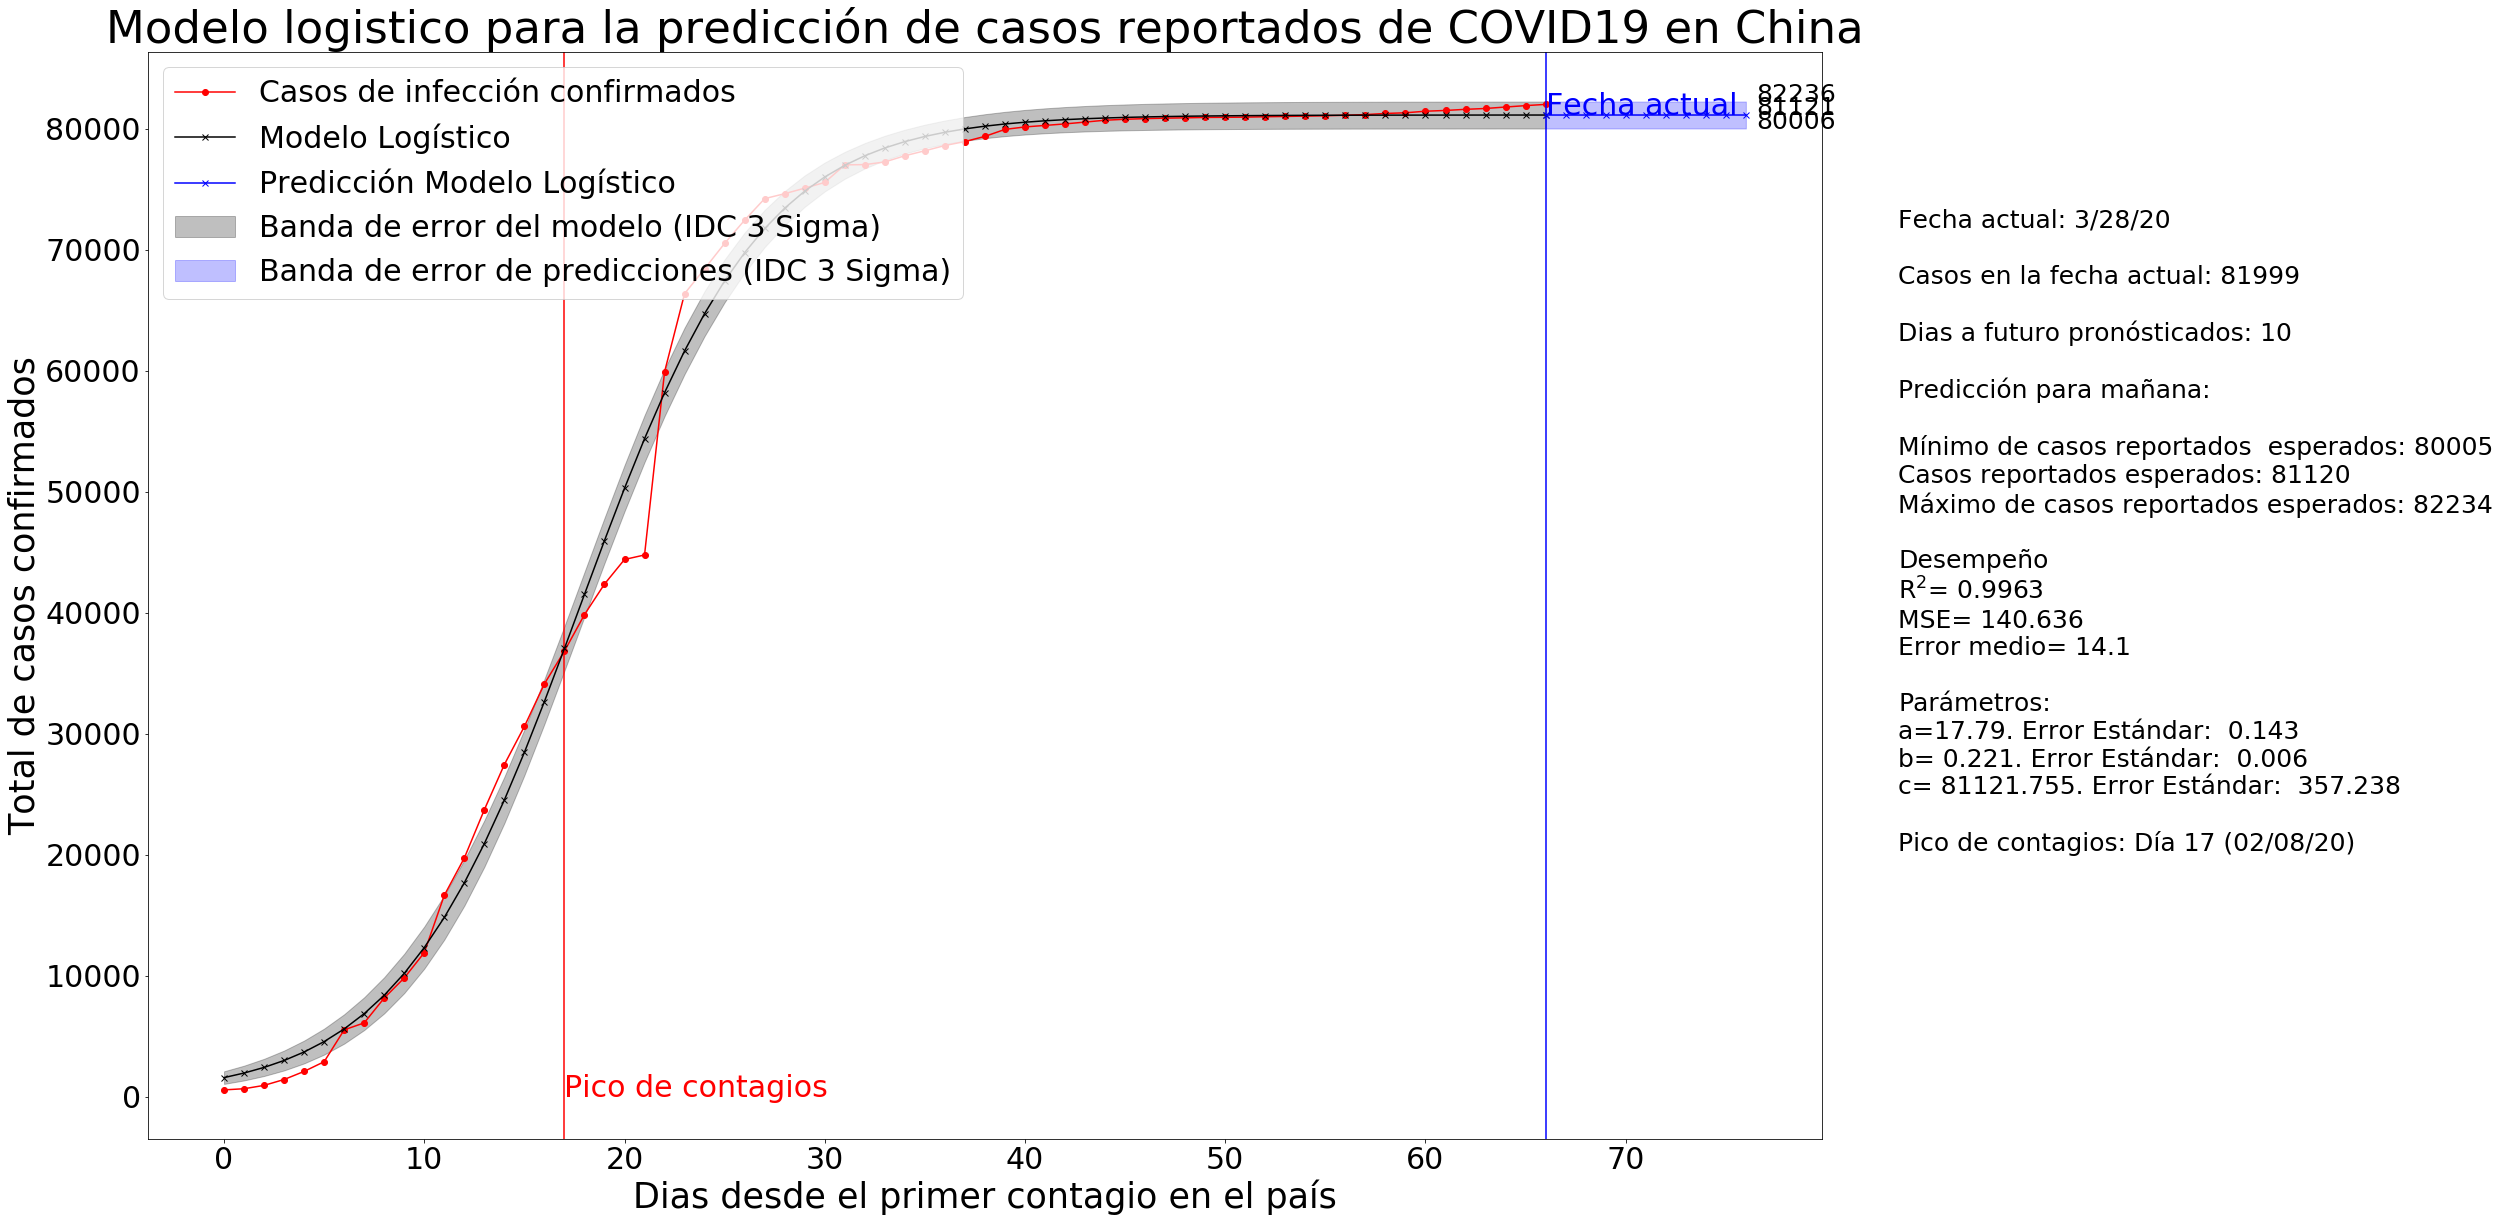

Predicciones y datos históricos para China


,Fecha,Casos reportados,Límite Inferior,Predicción,Límite Superior
66,03/28/20,81999.0,80005.0,81120.0,82234.0
67,03/29/20,NaN,80006.0,81120.0,82235.0
68,03/30/20,NaN,80006.0,81121.0,82235.0
69,03/31/20,NaN,80006.0,81121.0,82235.0
70,04/01/20,NaN,80006.0,81121.0,82236.0
71,04/02/20,NaN,80006.0,81121.0,82236.0
72,04/03/20,NaN,80006.0,81121.0,82236.0
73,04/04/20,NaN,80006.0,81121.0,82236.0
74,04/05/20,NaN,80006.0,81121.0,82236.0
75,04/06/20,NaN,80006.0,81121.0,82236.0


In [38]:
Pais="China"
dias_predecir=10
prediccion=modelo_rlog_covid_pais_dias_a_predecir(Pais, dias_predecir)
print("Predicciones y datos históricos para "+Pais)
prediccion.tail(dias_predecir+1)

Datos de casos confirmados de Spain: 
      fecha confirmados
0    2/1/20           1
1    2/2/20           1
2    2/3/20           1
3    2/4/20           1
4    2/5/20           1
5    2/6/20           1
6    2/7/20           1
7    2/8/20           1
8    2/9/20           2
9   2/10/20           2
10  2/11/20           2
11  2/12/20           2
12  2/13/20           2
13  2/14/20           2
14  2/15/20           2
15  2/16/20           2
16  2/17/20           2
17  2/18/20           2
18  2/19/20           2
19  2/20/20           2
20  2/21/20           2
21  2/22/20           2
22  2/23/20           2
23  2/24/20           2
24  2/25/20           6
25  2/26/20          13
26  2/27/20          15
27  2/28/20          32
28  2/29/20          45
29   3/1/20          84
30   3/2/20         120
31   3/3/20         165
32   3/4/20         222
33   3/5/20         259
34   3/6/20         400
35   3/7/20         500
36   3/8/20         673
37   3/9/20        1073
38  3/10/20        1695
39

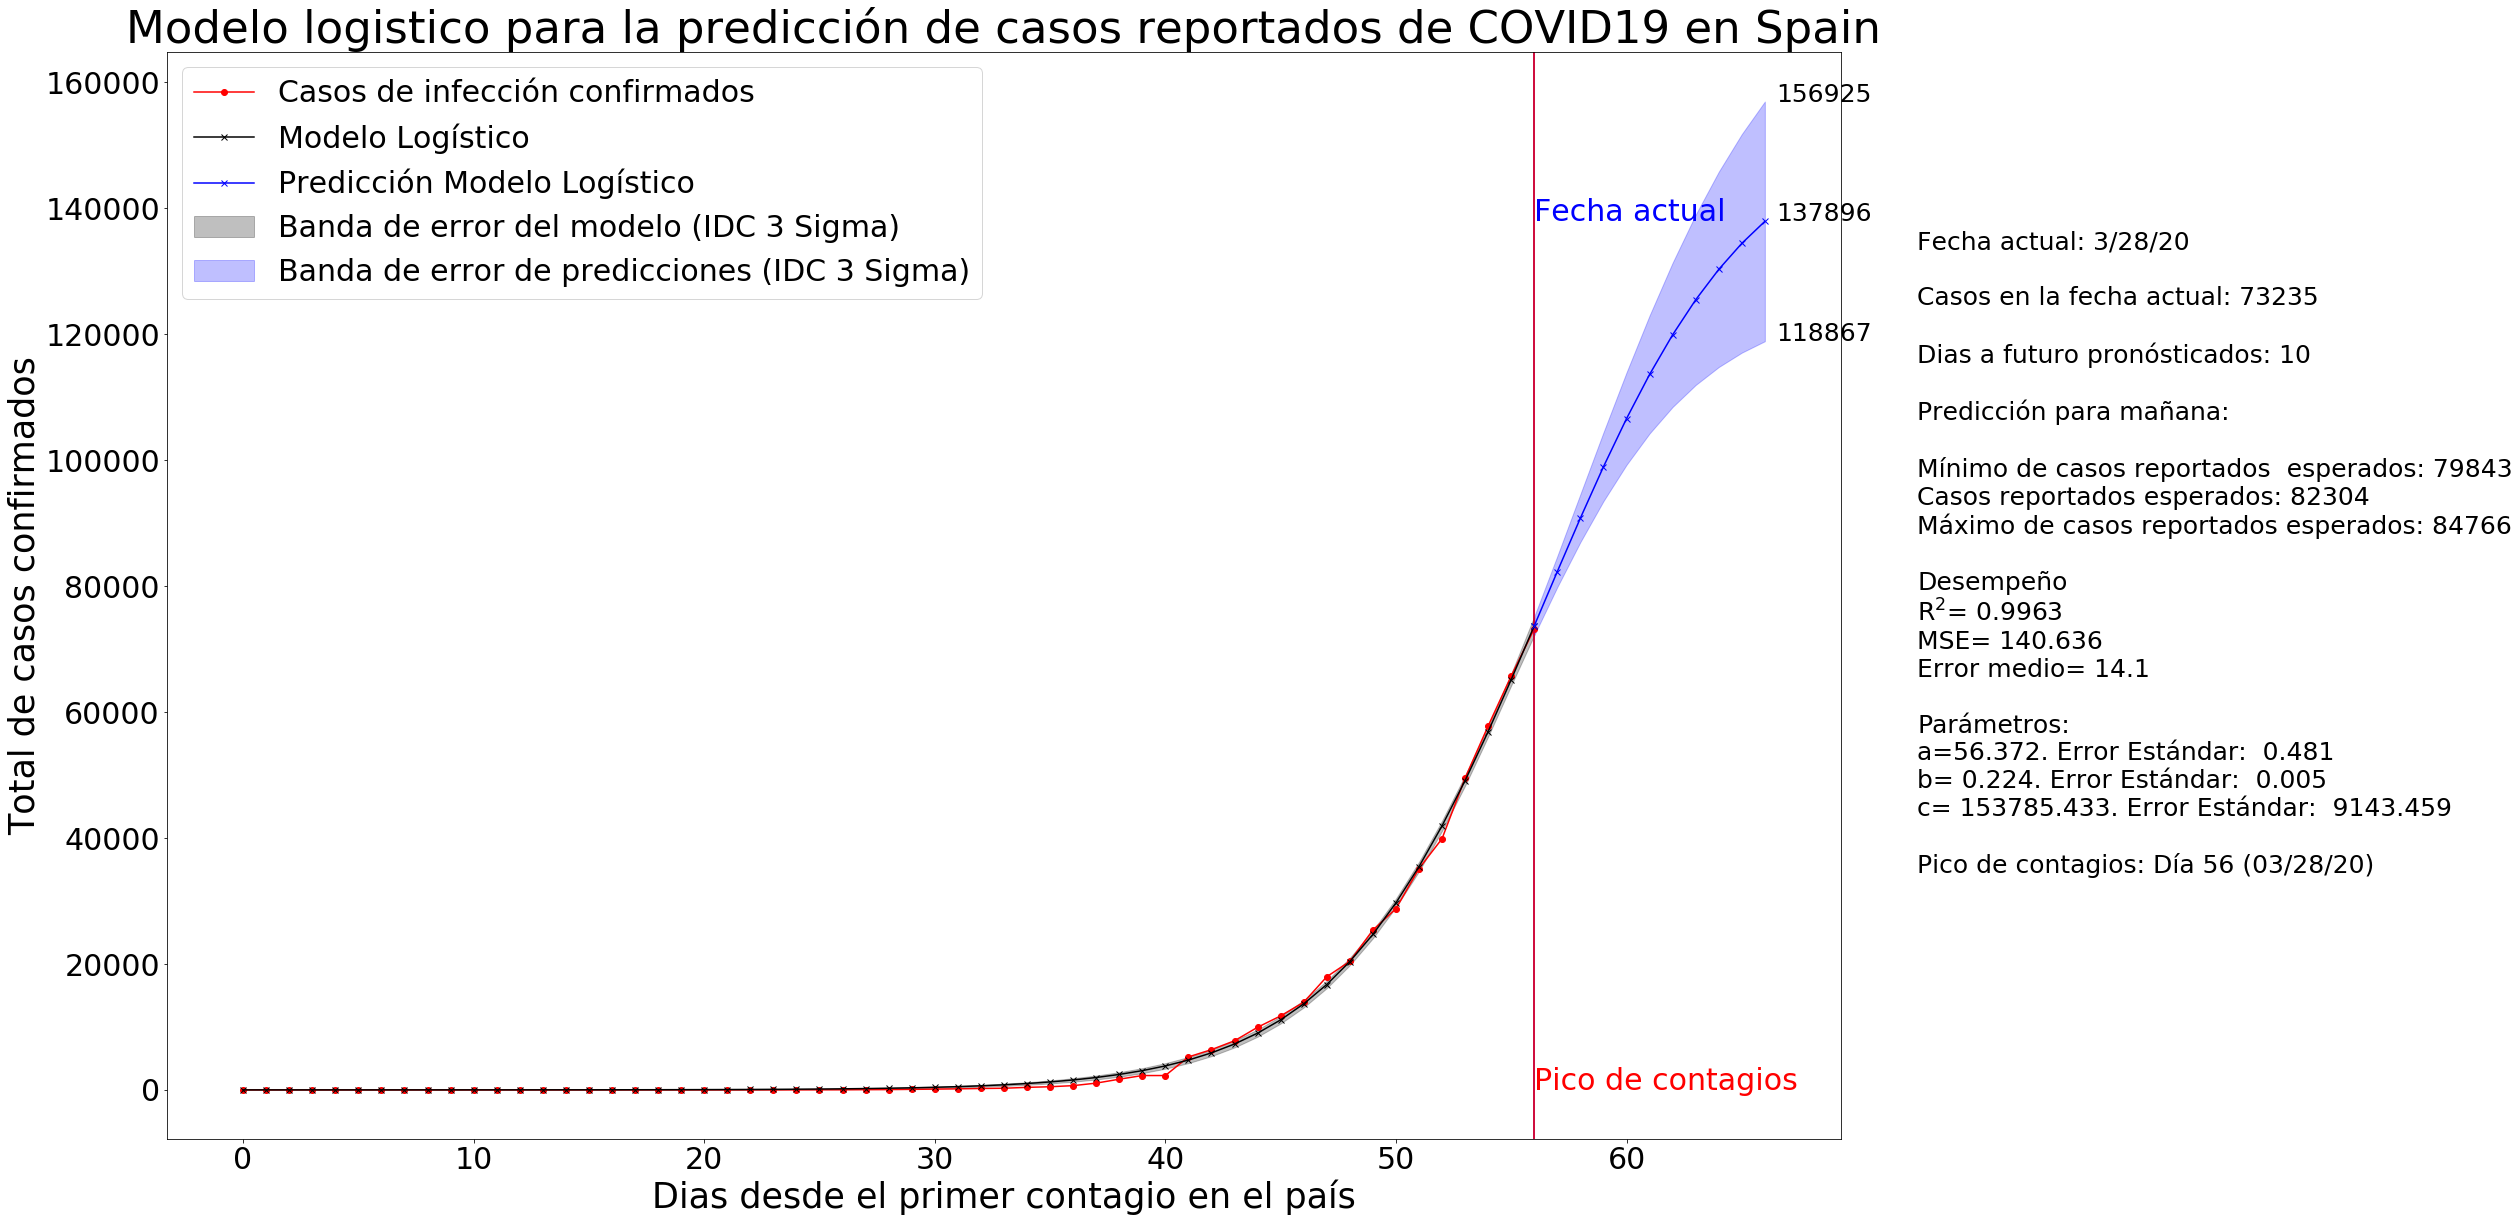

Predicciones y datos históricos para Spain


,Fecha,Casos reportados,Límite Inferior,Predicción,Límite Superior
56,03/28/20,73235.0,72202.0,73687.0,75171.0
57,03/29/20,NaN,79843.0,82305.0,84766.0
58,03/30/20,NaN,86982.0,90788.0,94594.0
59,03/31/20,NaN,93480.0,98935.0,104390.0
60,04/01/20,NaN,99241.0,106577.0,113912.0
61,04/02/20,NaN,104223.0,113586.0,122950.0
62,04/03/20,NaN,108435.0,119886.0,131338.0
63,04/04/20,NaN,111925.0,125445.0,138965.0
64,04/05/20,NaN,114769.0,130271.0,145773.0
65,04/06/20,NaN,117054.0,134402.0,151751.0


In [39]:
Pais="Spain"
dias_predecir=10
prediccion=modelo_rlog_covid_pais_dias_a_predecir(Pais, dias_predecir)
print("Predicciones y datos históricos para "+Pais)
prediccion.tail(dias_predecir+1)

Datos de casos confirmados de Germany: 
      fecha confirmados
0   1/27/20           1
1   1/28/20           4
2   1/29/20           4
3   1/30/20           4
4   1/31/20           5
..      ...         ...
57  3/24/20       32986
58  3/25/20       37323
59  3/26/20       43938
60  3/27/20       50871
61  3/28/20       57695

[62 rows x 2 columns]


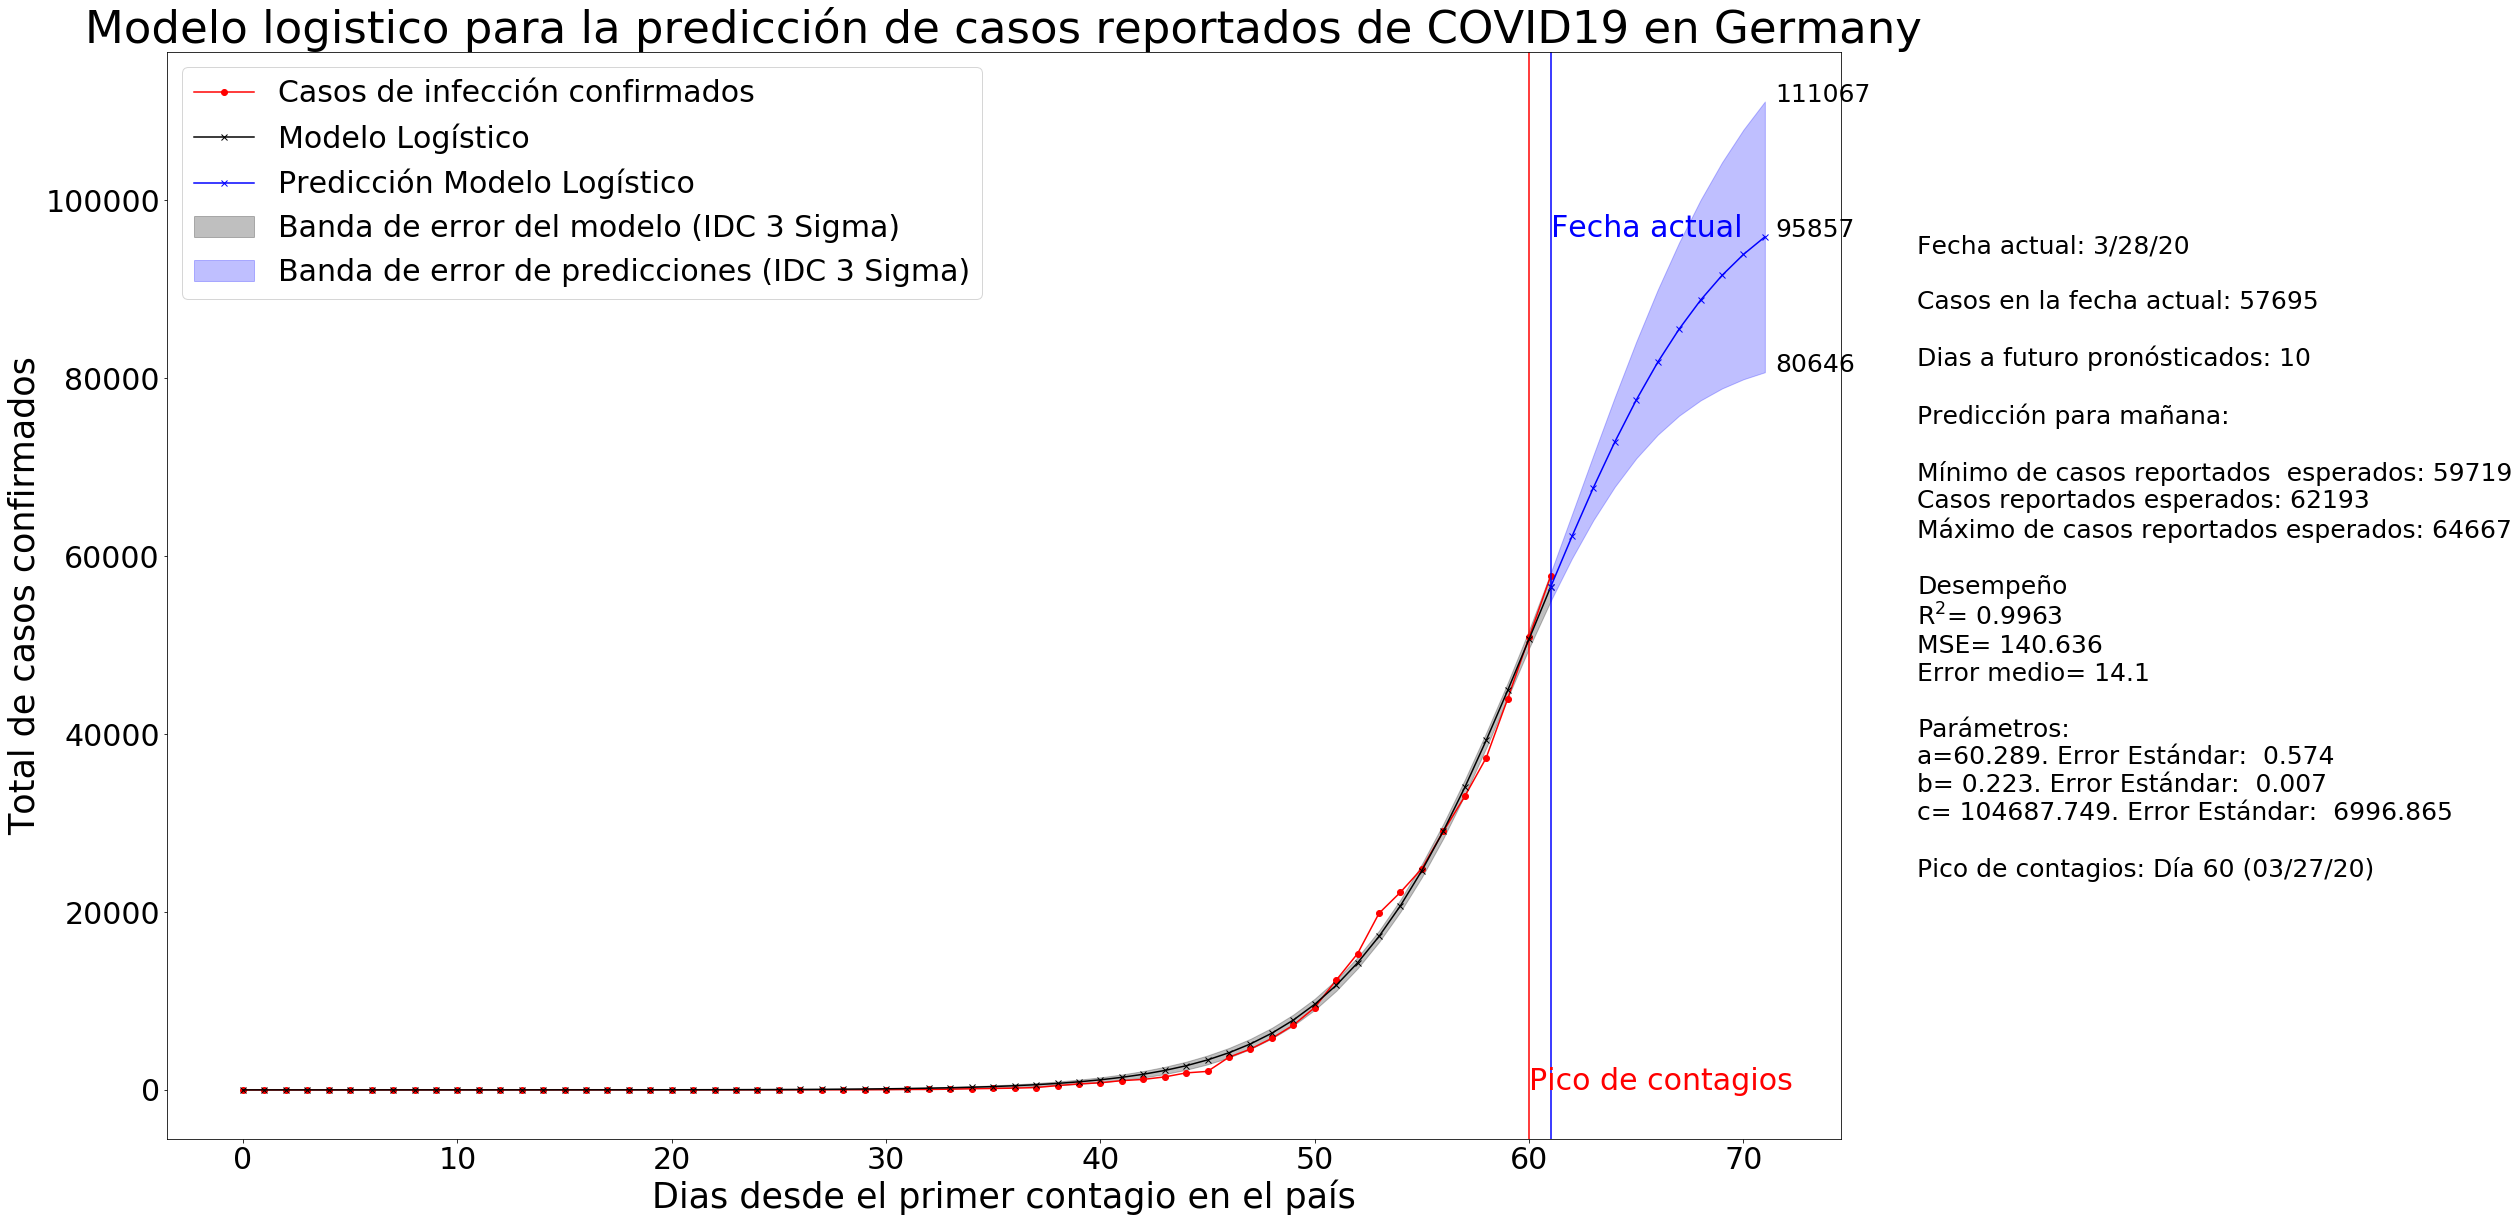

Predicciones y datos históricos para Germany


,Fecha,Casos reportados,Límite Inferior,Predicción,Límite Superior
61,03/28/20,57695.0,54904.0,56477.0,58050.0
62,03/29/20,NaN,59720.0,62194.0,64668.0
63,03/30/20,NaN,64025.0,67677.0,71328.0
64,03/31/20,NaN,67780.0,72815.0,77850.0
65,04/01/20,NaN,70971.0,77526.0,84081.0
66,04/02/20,NaN,73618.0,81760.0,89902.0
67,04/03/20,NaN,75768.0,85497.0,95226.0
68,04/04/20,NaN,77481.0,88744.0,100008.0
69,04/05/20,NaN,78822.0,91526.0,104231.0
70,04/06/20,NaN,79857.0,93882.0,107907.0


In [20]:
Pais="Germany"
dias_predecir=10
prediccion=modelo_rlog_covid_pais_dias_a_predecir(Pais, dias_predecir)
print("Predicciones y datos históricos para "+Pais)
prediccion.tail(dias_predecir+1)